## 2022 EY Challenge - Digital Elevation

This notebook can be used to create a Digital Elevation Model (DEM) dataset. This elevation information, along with calculated slope, can be used as a "predictor variable" to relate to species samples. It is believed that terrain elevation may be a constraint for species habitat. The baseline data is 30-meters spatial resolution [Copernicus DEM GLO-30] and can be found in the MS Planetary Computer catalog: (https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30)

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features
import folium
import math

# Import Planetary Computer tools
import pystac_client
import planetary_computer

### Define the analysis region and view on a map

First, we define our area of interest using latitude and longitude coordinates. Our test region is near Richmond, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [2]:
# Define the bounding box using corners
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner (longitude, latitude)
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner (longitude, latitude)

In [3]:
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

In [4]:
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None):

    margin = -0.5
    zoom_bias = 0
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 
    center = [np.mean(latitude), np.mean(longitude)]
    
    map_hybrid = folium.Map(location=center,zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",attr="Google")
    
    line_segments = [(latitude[0],longitude[0]),(latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),(latitude[1],longitude[0]),
                     (latitude[0],longitude[0])]
    
    map_hybrid.add_child(folium.features.PolyLine(locations=line_segments,color='red',opacity=0.8))
    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [5]:
# Plot bounding box on a map
f = folium.Figure(width=600, height=600)
m = display_map(latitude,longitude)
f.add_child(m)

### Discover and load the data for analysis

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will look for data tiles (1-degree square) that intersect our bounding box. 

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(bbox=bbox,collections=["cop-dem-glo-30"])

In [7]:
items = list(search.get_items())
print('Number of 1-degree data tiles connected to our region:',len(items))

Number of 1-degree data tiles connected to our region: 1


Next, we'll load the elevation data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray, calculate the slope between pixels, and then "clip" the data to only the pixels within our region (bounding box). The dataset includes elevation (meters) at lat-lon positions (EPSG:4326) at a spatial separation of 30-meters per pixel. 

In [8]:
signed_asset = planetary_computer.sign(items[0].assets["data"])

In [9]:
data_elevation = (xr.open_rasterio(signed_asset.href).squeeze().drop("band"))

We will create a function to calculate slope (in percent) between pixels. The "dem" parameter is the elevation dataset to use for the slope calculation. The "resolution" parameter is the pixel spatial resolution of the elevation dataset.

In [10]:
from scipy.ndimage import convolve

In [11]:
def slope_pct(dem, resolution):
    # Kernel for rate of elevation change in x-axis.
    dx_kernel = np.array([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])
    # Kernel for rate of elevation change in y-axis.
    dy_kernel = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])
    # Rate of change calculations for each axis.
    dx = convolve(dem, dx_kernel) / (8 * resolution)
    dy = convolve(dem, dy_kernel) / (8 * resolution)
    # Return rise/run * 100 for slope percent.
    return np.sqrt(np.square(dx) + np.square(dy)) * 100

In [12]:
data_slope = xr.DataArray(slope_pct(data_elevation,30.0),coords=dict(data_elevation.coords))

In [13]:
# Create a combined dataset that includes elevation and slope
Combined_Data = xr.Dataset({'elevation':data_elevation,'slope':data_slope},coords=data_elevation.coords)

In [14]:
Clipped_Data = Combined_Data.sel(x=slice(min_lon,max_lon),y=slice(max_lat,min_lat))

### Display elevation and slope products

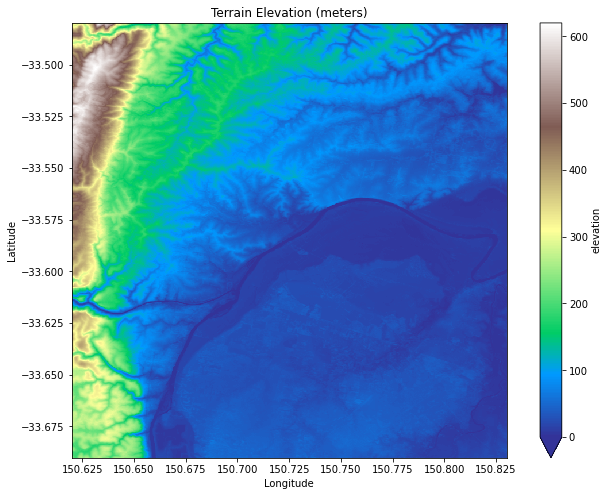

In [15]:
Clipped_Data.elevation.plot.imshow(size=8,cmap=plt.cm.terrain,vmin=0.0,vmax=np.max(Clipped_Data.elevation))
plt.gca().set_aspect('equal')
plt.title('Terrain Elevation (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

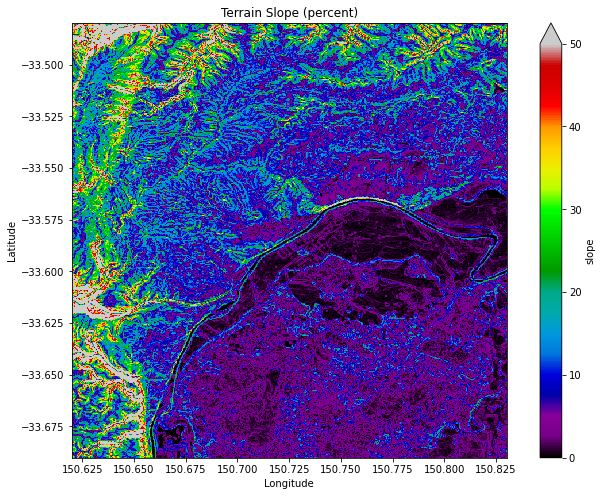

In [16]:
Clipped_Data.slope.plot.imshow(size=8, cmap=plt.cm.nipy_spectral, vmin=0, vmax=50)
plt.gca().set_aspect('equal')
plt.title('Terrain Slope (percent)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Save the output data in a GeoTIFF file

In [17]:
filename = "DEM_sample8.tiff"

In [18]:
# Set the dimensions of file in pixels
height = Clipped_Data.elevation.shape[0]
width = Clipped_Data.elevation.shape[1]

In [25]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(min_lon,min_lat,max_lon,max_lat,width,height)
Clipped_Data.rio.write_crs("epsg:4326", inplace=True)
Clipped_Data.rio.write_transform(transform=gt, inplace=True);

In [21]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,crs='epsg:4326',
                   transform=gt,count=2,compress='lzw',dtype='float32') as dst:
    dst.write(Clipped_Data.elevation,1)
    dst.write(Clipped_Data.slope,2)
    print (dst.crs)
    print (dst.transform)
    dst.close()

EPSG:4326
| 0.00, 0.00, 150.62|
| 0.00,-0.00,-33.48|
| 0.00, 0.00, 1.00|


In [22]:
# Show the location and size of the new output file
!ls *.tiff -lah

-rw-rw-r-- 1 jovyan users 122M Jan 19 17:49 DEM_sample.tiff
-rw-r--r-- 1 jovyan users 5.2M Jan 21 18:19 DEM_sample8.tiff
-rw-rw-r-- 1 jovyan users 273K Jan  7 17:21 Land_Cover_sample.tiff
-rw-rw-r-- 1 jovyan users  49M Jan  5 20:26 S2_mosaic_sample.tiff
-rw-rw-r-- 1 jovyan users  305 Jan  6 01:03 Weather_sample.tiff


### How will the participants use this data?
The GeoTIFF file will contain the Lat-Lon coordinates of each pixel and will also contain the elevation and slope for each pixel as separate data layers. Since the FrogID data is also Lat-Lon position, it is possible to find the closest pixel using code similar to what is demonstrated below. Once this pixel is found, then the corresponding elevation and slope data values can be used for modeling species distribution. 

In [23]:
# This is an example for a specific Lon-Lat location randomly selected within our sample region.
values = Clipped_Data.elevation.sel(x=150.71, y=-33.51, method="nearest").values    
print("This is the elevation in meters for the closest pixel: ", np.round(values,1))
values = Clipped_Data.slope.sel(x=150.71, y=-33.51, method="nearest").values    
print("This is the slope in percent for the closest pixel: ", np.round(values,1))

This is the elevation in meters for the closest pixel:  125.8
This is the slope in percent for the closest pixel:  9.2
